In [53]:
from keras.models import load_model
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import join
import cv2
import numpy as np
import time
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
import pickle
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

detector = MTCNN()
embedding_size = 128

def l2_distance(a, b):
    diff = a - b
    return np.sqrt(np.sum(diff*diff))

def cosine_distance(arr1, arr2):
    scalar_product = np.sum(arr1*arr2)
    norm1 = np.sqrt(np.sum(arr1*arr1))
    norm2 = np.sqrt(np.sum(arr2*arr2))
    return scalar_product/(norm1*norm2)

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def loadImage(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32)

def normalizeImage(image):
    mean, std = image.mean(), image.std()
    image = (image - mean) / std
    return image

def extractFaces(image, normalize=True):
    results = detector.detect_faces(image)
    faces = np.zeros((0, 160, 160, 3), dtype=np.uint8)
    coords = np.zeros((0, 4), dtype=np.int32)
    for i in range(len(results)):
        x1, y1, w, h = results[i]['box']
        face = image[y1:(y1+h), x1:(x1+w)]
        if face.shape[0]*face.shape[1]*face.shape[2] == 0:
            continue
        face = cv2.resize(face, (160, 160))
        if normalize:
            face = normalizeImage(face)
        faces = np.append(faces, face.reshape(1, 160, 160, 3), axis=0)
        rect_coords = np.array([x1, y1, x1+w, y1+h]).reshape(1, 4)
        coords = np.append(coords, rect_coords, axis=0)
    return faces, coords

class Predictor:
    def __init__(self, model_path, face_database_path, classifier_path=None, identities_path=None):
        self.model = load_model(model_path)
        if identities_path is not None:
            self.identities = self.loadIdentities(identities_path)
        if classifier_path is not None:
            self.loadClassifier(classifier_path)
        else:
            self.classifier = SVC(kernel='linear', probability=True)
            X, y = self.processDatabase(face_database_path)
            print(X)
            print(y)
            self.classifier.fit(X, y)
            self.X = X
            self.y = y
    
    def processDatabase(self, face_database_path, detect_faces=True):
        folders = [join(face_database_path, f) for f in listdir(face_database_path)]
        names = []
        embeddings = np.zeros((0, embedding_size))
        for folder in folders:
            files = [join(folder, f) for f in listdir(folder)]
            for file in files:
                image = loadImage(file)
                if detect_faces:
                    faces, coords = extractFaces(image, normalize=False)
                    if faces.shape[0] == 0:
                        continue
                    image = faces[0]
                name = folder.split("\\", 1)[1]
                image = cv2.resize(image, (160, 160))
                image = normalizeImage(image)
                plt.imshow(image)
                plt.show()
                embedding = self.computeEmbeddings(image)
                embeddings = np.append(embedding, embeddings, axis=0)
                names.append(name)
        embeddings = l2_normalize(embeddings)
        print(names)
        labels, self.identities = self.toCategorical(names)
        print(self.identities)
        print(labels)
        return embeddings, labels
    
    def toCategorical(self, str_arr):
        values = list(set(str_arr))
        keys = list(range(len(values)))
        str_to_cat = dict(zip(values, keys))
        cat_to_str = dict(zip(keys, values))
        
        categorical = np.array([str_to_cat[string] for string in str_arr], dtype=np.int32)
        
        return categorical, cat_to_str
    
    def computeEmbeddings(self, images):
        return self.model.predict(images.reshape(-1, 160, 160, 3))
    
    def saveClassifier(self, path, classifier):
        with open(path, 'wb') as f:
            pickle.dump(classifier, f)
            
    def loadClassifier(self, path):
        with open(path, 'rb') as f:
            classifier = pickle.load(f)
        return classifier
    
    def saveIdentities(self, path, identities):
        with open(path, 'wb') as f:
            pickle.dump(identities, f)            
        
    def loadIdentities(self, path):
        with open(path, 'rb') as f:
            identities = pickle.load(f)
        return dict(identities)
    
    def saveConfig(self, clf_path, id_path):
        self.saveClassifier(clf_path, self.classifier)
        self.saveIdentities(id_path, self.identities)
        
    def predictFaces(self, image):
        faces, coords = extractFaces(image)
        if faces.shape[0] == 0:
            return image
        emb = self.computeEmbeddings(faces)
        emb = l2_normalize(emb)
        clear_output(wait=True)
        #for i in range(self.X.shape[0]):
        #    print(self.identities[self.y[i]], ": ", cosine_distance(emb.reshape(128), self.X[i]))
        classes = self.classifier.predict(emb)
        probs = self.classifier.predict_proba(emb)
        for i in range(classes.shape[0]):
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            cv2.rectangle(image, (coords[i, 0], coords[i, 1]), (coords[i, 2], coords[i, 3]), (0, 255, 0), 2)
            clear_output(wait=True)
            print(np.max(probs[i]))
            if np.max(probs[i]) < 0.2:
                label = "Unknown person"
            else:
                label = self.identities[classes[i]]
            print(classes[i])
            cv2.putText(image, label, (coords[i, 0], coords[i, 1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        return image

In [ ]:
system = Predictor('models/facenet_keras.h5', 'test images')

cap = cv2.VideoCapture(0)
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:
        output = system.predictFaces(frame)
        cv2.imshow("Detections", output)
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


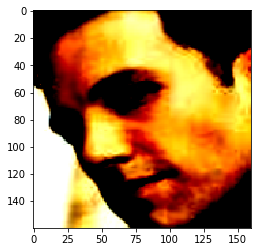

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


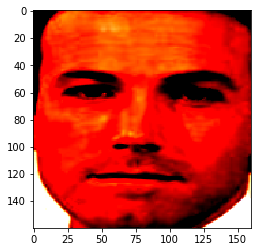

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


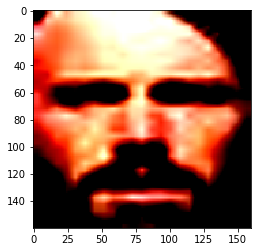

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


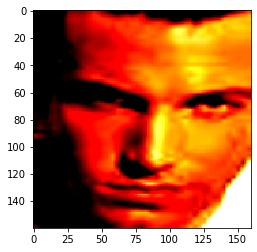

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


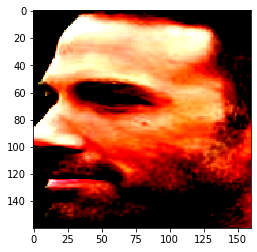

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


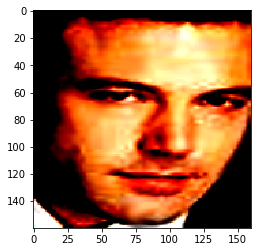

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


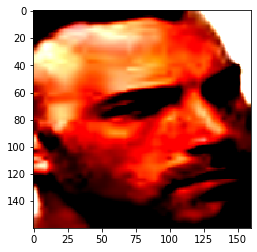

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


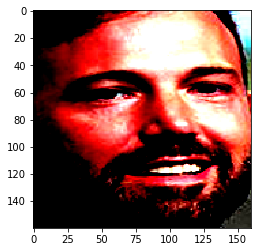

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


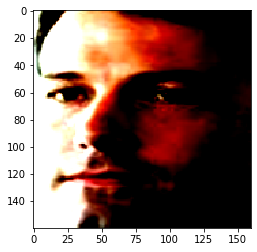

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


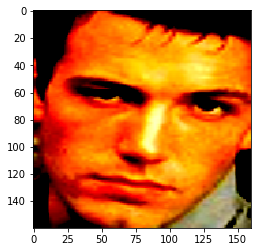

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


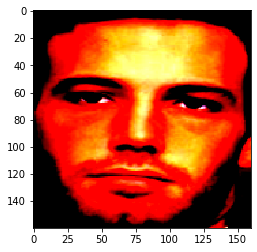

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


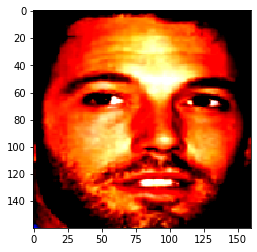

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


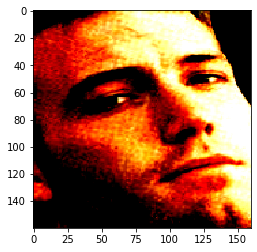

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


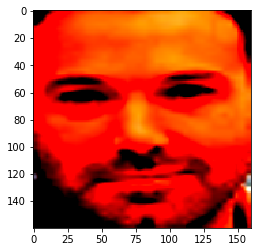

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


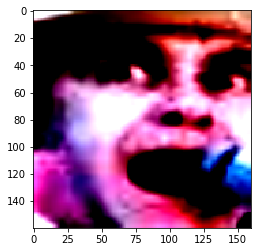

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


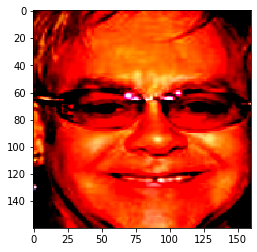

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


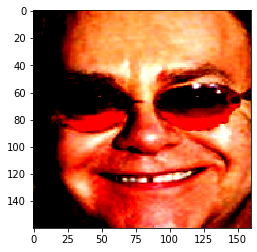

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


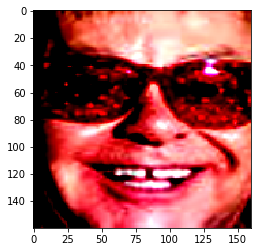

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


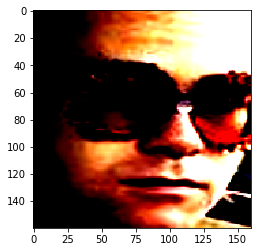

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


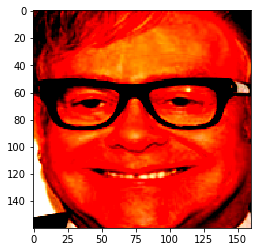

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


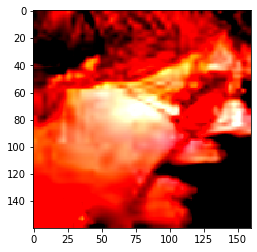

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


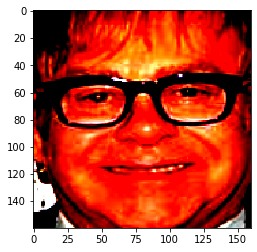

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


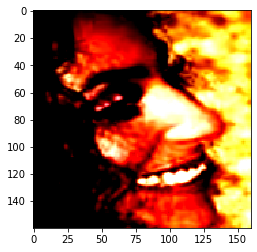

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


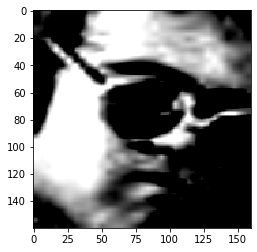

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


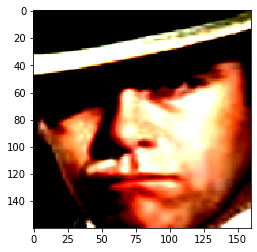

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


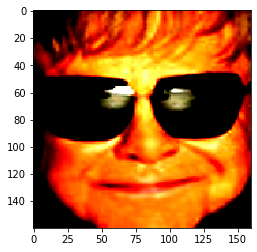

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


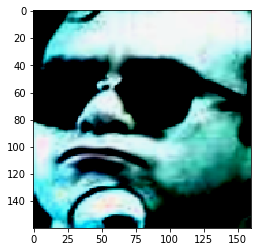

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


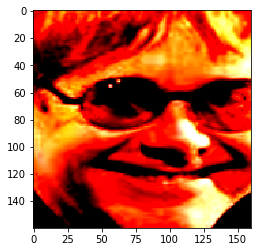

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


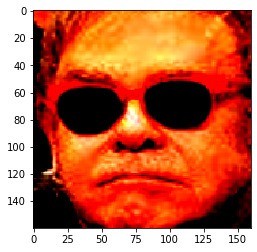

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


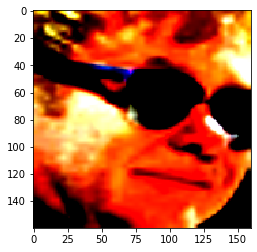

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


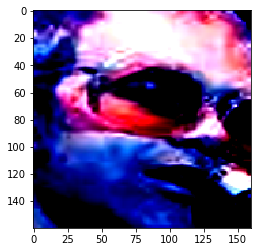

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


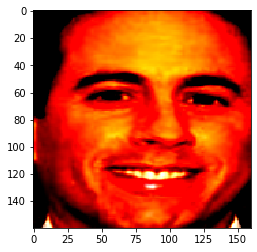

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


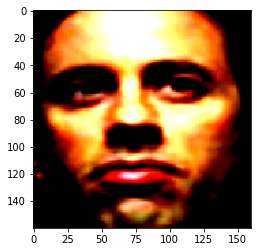

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


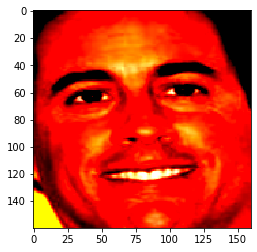

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


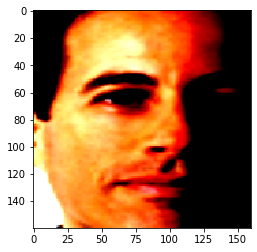

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


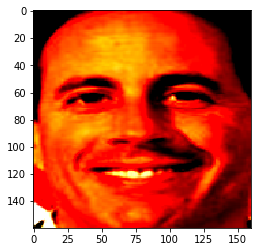

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


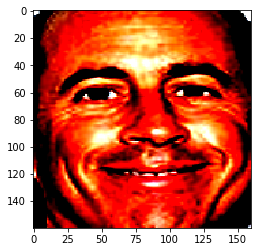

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


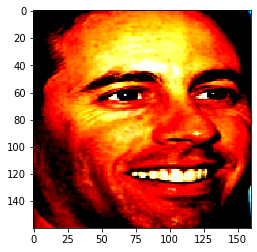

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


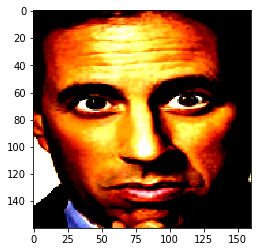

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


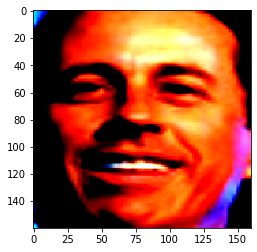

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


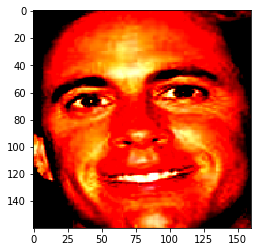

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


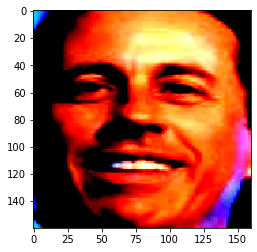

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


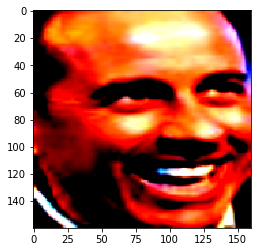

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


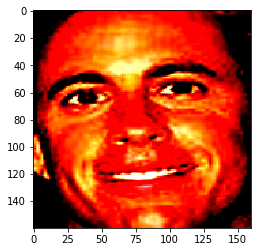

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


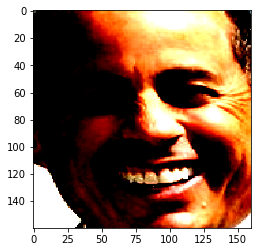

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


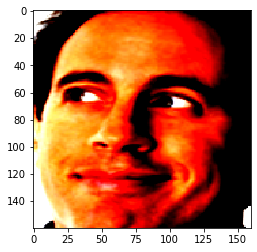

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


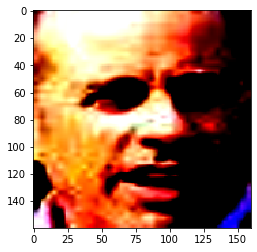

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


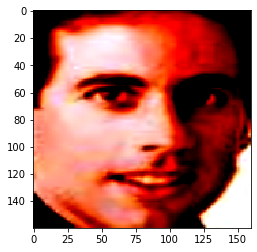

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


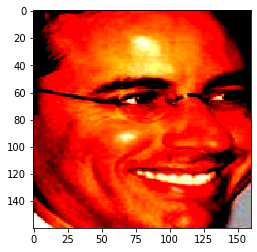

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


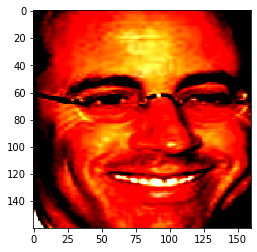

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


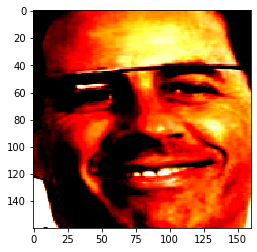

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


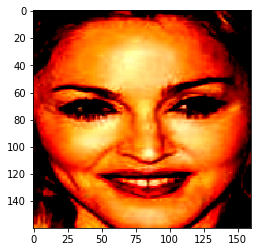

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


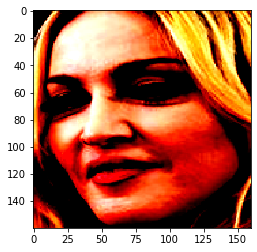

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


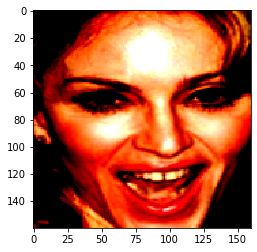

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


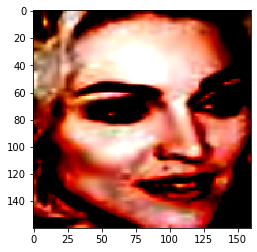

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


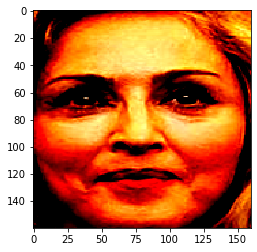

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


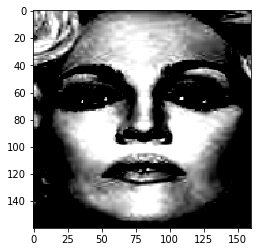

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


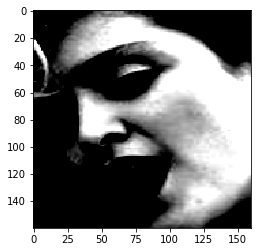

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


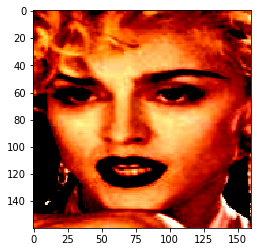

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


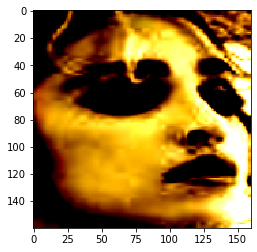

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


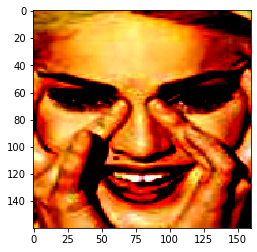

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


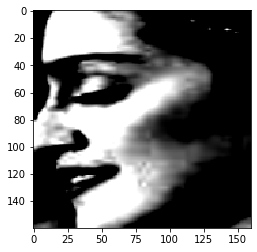

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


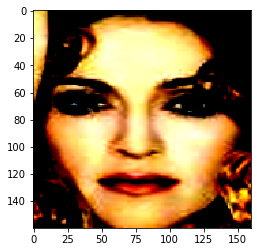

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


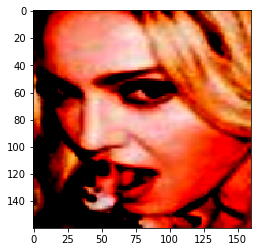

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


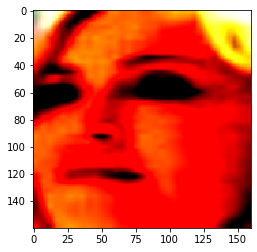

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


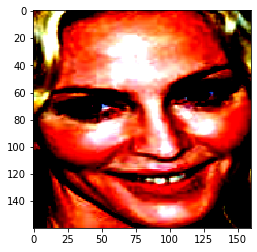

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


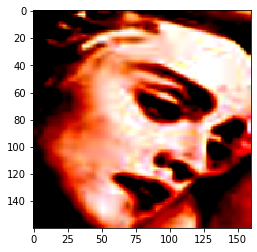

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


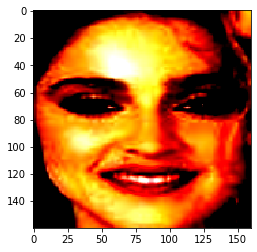

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


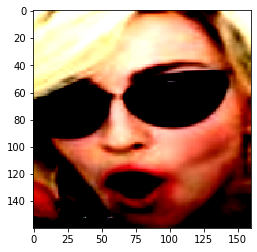

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


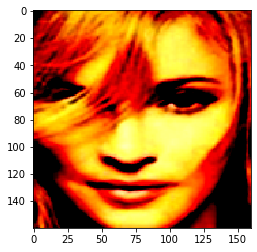

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


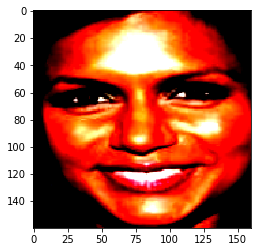

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


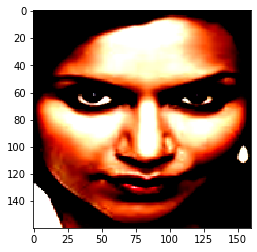

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


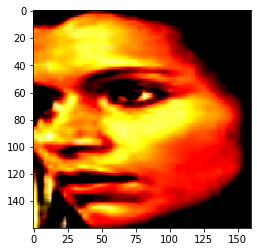

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


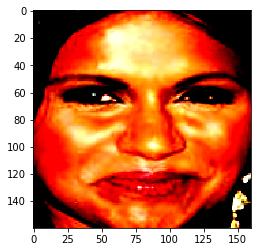

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


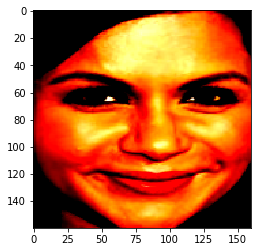

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


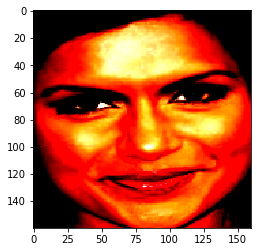

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


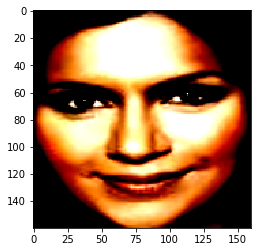

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


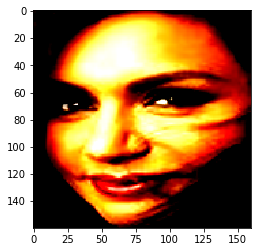

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


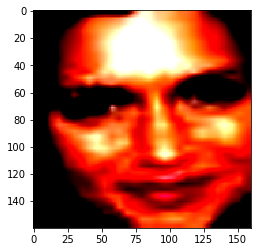

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


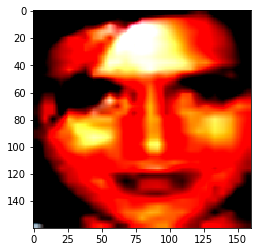

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


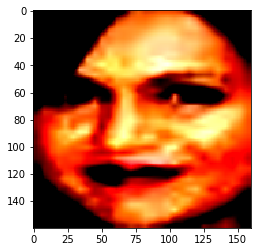

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


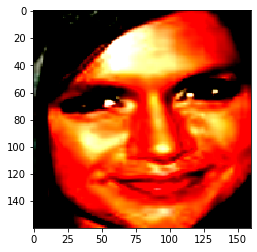

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


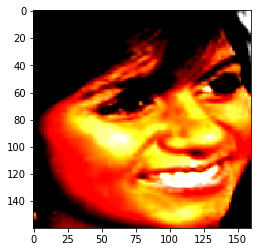

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


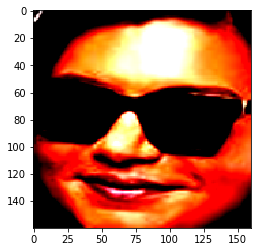

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


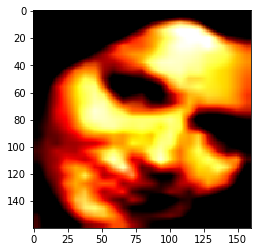

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


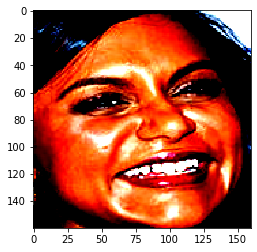

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


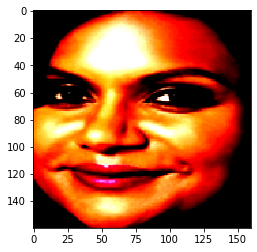

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


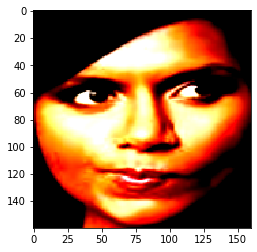

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


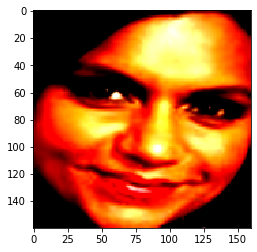

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


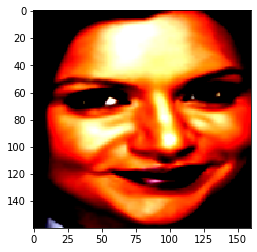

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


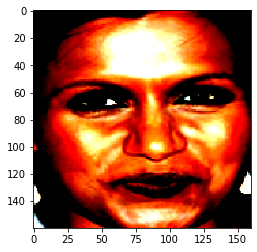

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


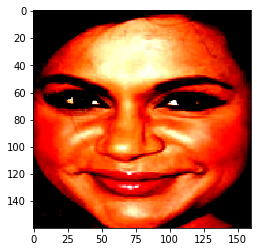

['ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'elton_john', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonna', 'madonn

In [54]:
system = Predictor('models/facenet_keras.h5', 'data/train')

In [49]:
cv2.imshow("Test", system.predictFaces(loadImage("data/val/ben_afflek/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTENDgMDUODczNDcNTcjpg.jpg")))
cv2.waitKey()
cv2.destroyAllWindows()

0.8034406633819601
2


In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

a = np.arange(5).reshape(1, -1)

enc = Normalizer()
print(l2_normalize(a))

[[0.         0.18257419 0.36514837 0.54772256 0.73029674]]
